# What do the wind relative to a platform look like? 

In [2]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
import spectrum

#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma
#function for coverting Matlab's datenum into Python's datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
#with modifications to support array input and output

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24

wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
ppc = '#ff6600'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Saildrone

In [3]:
sd_path = '/Users/xedhjo/Documents/Projects/mapping datasets/USV metadata/data/'
sd_files = [f for f in os.listdir(sd_path) if os.path.isfile(os.path.join(sd_path, f))]
DS = []
for i in tqdm(range(len(sd_files))):
    tmp = xr.open_dataset(sd_path+sd_files[i]).squeeze()
    DS.append(tmp.swap_dims({list(tmp.dims)[0]:'time'}))

  0%|          | 0/31 [00:00<?, ?it/s]

In [55]:
len(DS)

31

In [13]:
def angle_diff(ds,var1,var2):
    return np.angle(np.exp(1j * np.deg2rad(ds[var1])) / np.exp(1j * np.deg2rad(ds[var2].values)), deg=True)

In [28]:
c = []
for i,ds in tqdm(enumerate(DS)):
    if ('UWND_MEAN' in list(ds.keys())):
        ds['wind_dir'] = ('time'), (np.arctan2(ds['UWND_MEAN'] .values, ds['VWND_MEAN'].values) * 180 / np.pi) % 360
        ds['wind_speed'] = ('time'), np.sqrt(ds['UWND_MEAN'] .values**2 + ds['VWND_MEAN'].values ** 2)
    if ('HDG' not in list(ds.keys())) & ('HDG_WING' not in list(ds.keys())):
        continue
    if 'COG' in list(ds.keys()):
        ds['hrw'] = ('time'),angle_diff(ds,'HDG','wind_dir')
        c.append('C0')
    else:
        ds['hrw'] = ('time'),angle_diff(ds,'HDG_WING','wind_dir')
        c.append('C1')



0it [00:00, ?it/s]

In [65]:
c = []
for i,ds in tqdm(enumerate(DS)):
    if ('UWND_MEAN' in list(ds.keys())):
        ds['wind_dir'] = ('time'), (np.arctan2(ds['UWND_MEAN'] .values, ds['VWND_MEAN'].values) * 180 / np.pi) % 360
        ds['wind_speed'] = ('time'), np.sqrt(ds['UWND_MEAN'] .values**2 + ds['VWND_MEAN'].values ** 2)
    if ('HDG' not in list(ds.keys())) & ('HDG_WING' not in list(ds.keys())):
        continue
    if 'COG' in list(ds.keys()):
        ds['hrw'] = ('time'),angle_diff(ds,'COG','wind_dir')
        c.append('C0')
    else:
        ds['hrw'] = ('time'),angle_diff(ds,'COG','wind_dir')
        c.append('C1')



0it [00:00, ?it/s]

0it [00:00, ?it/s]

IndexError: list index out of range

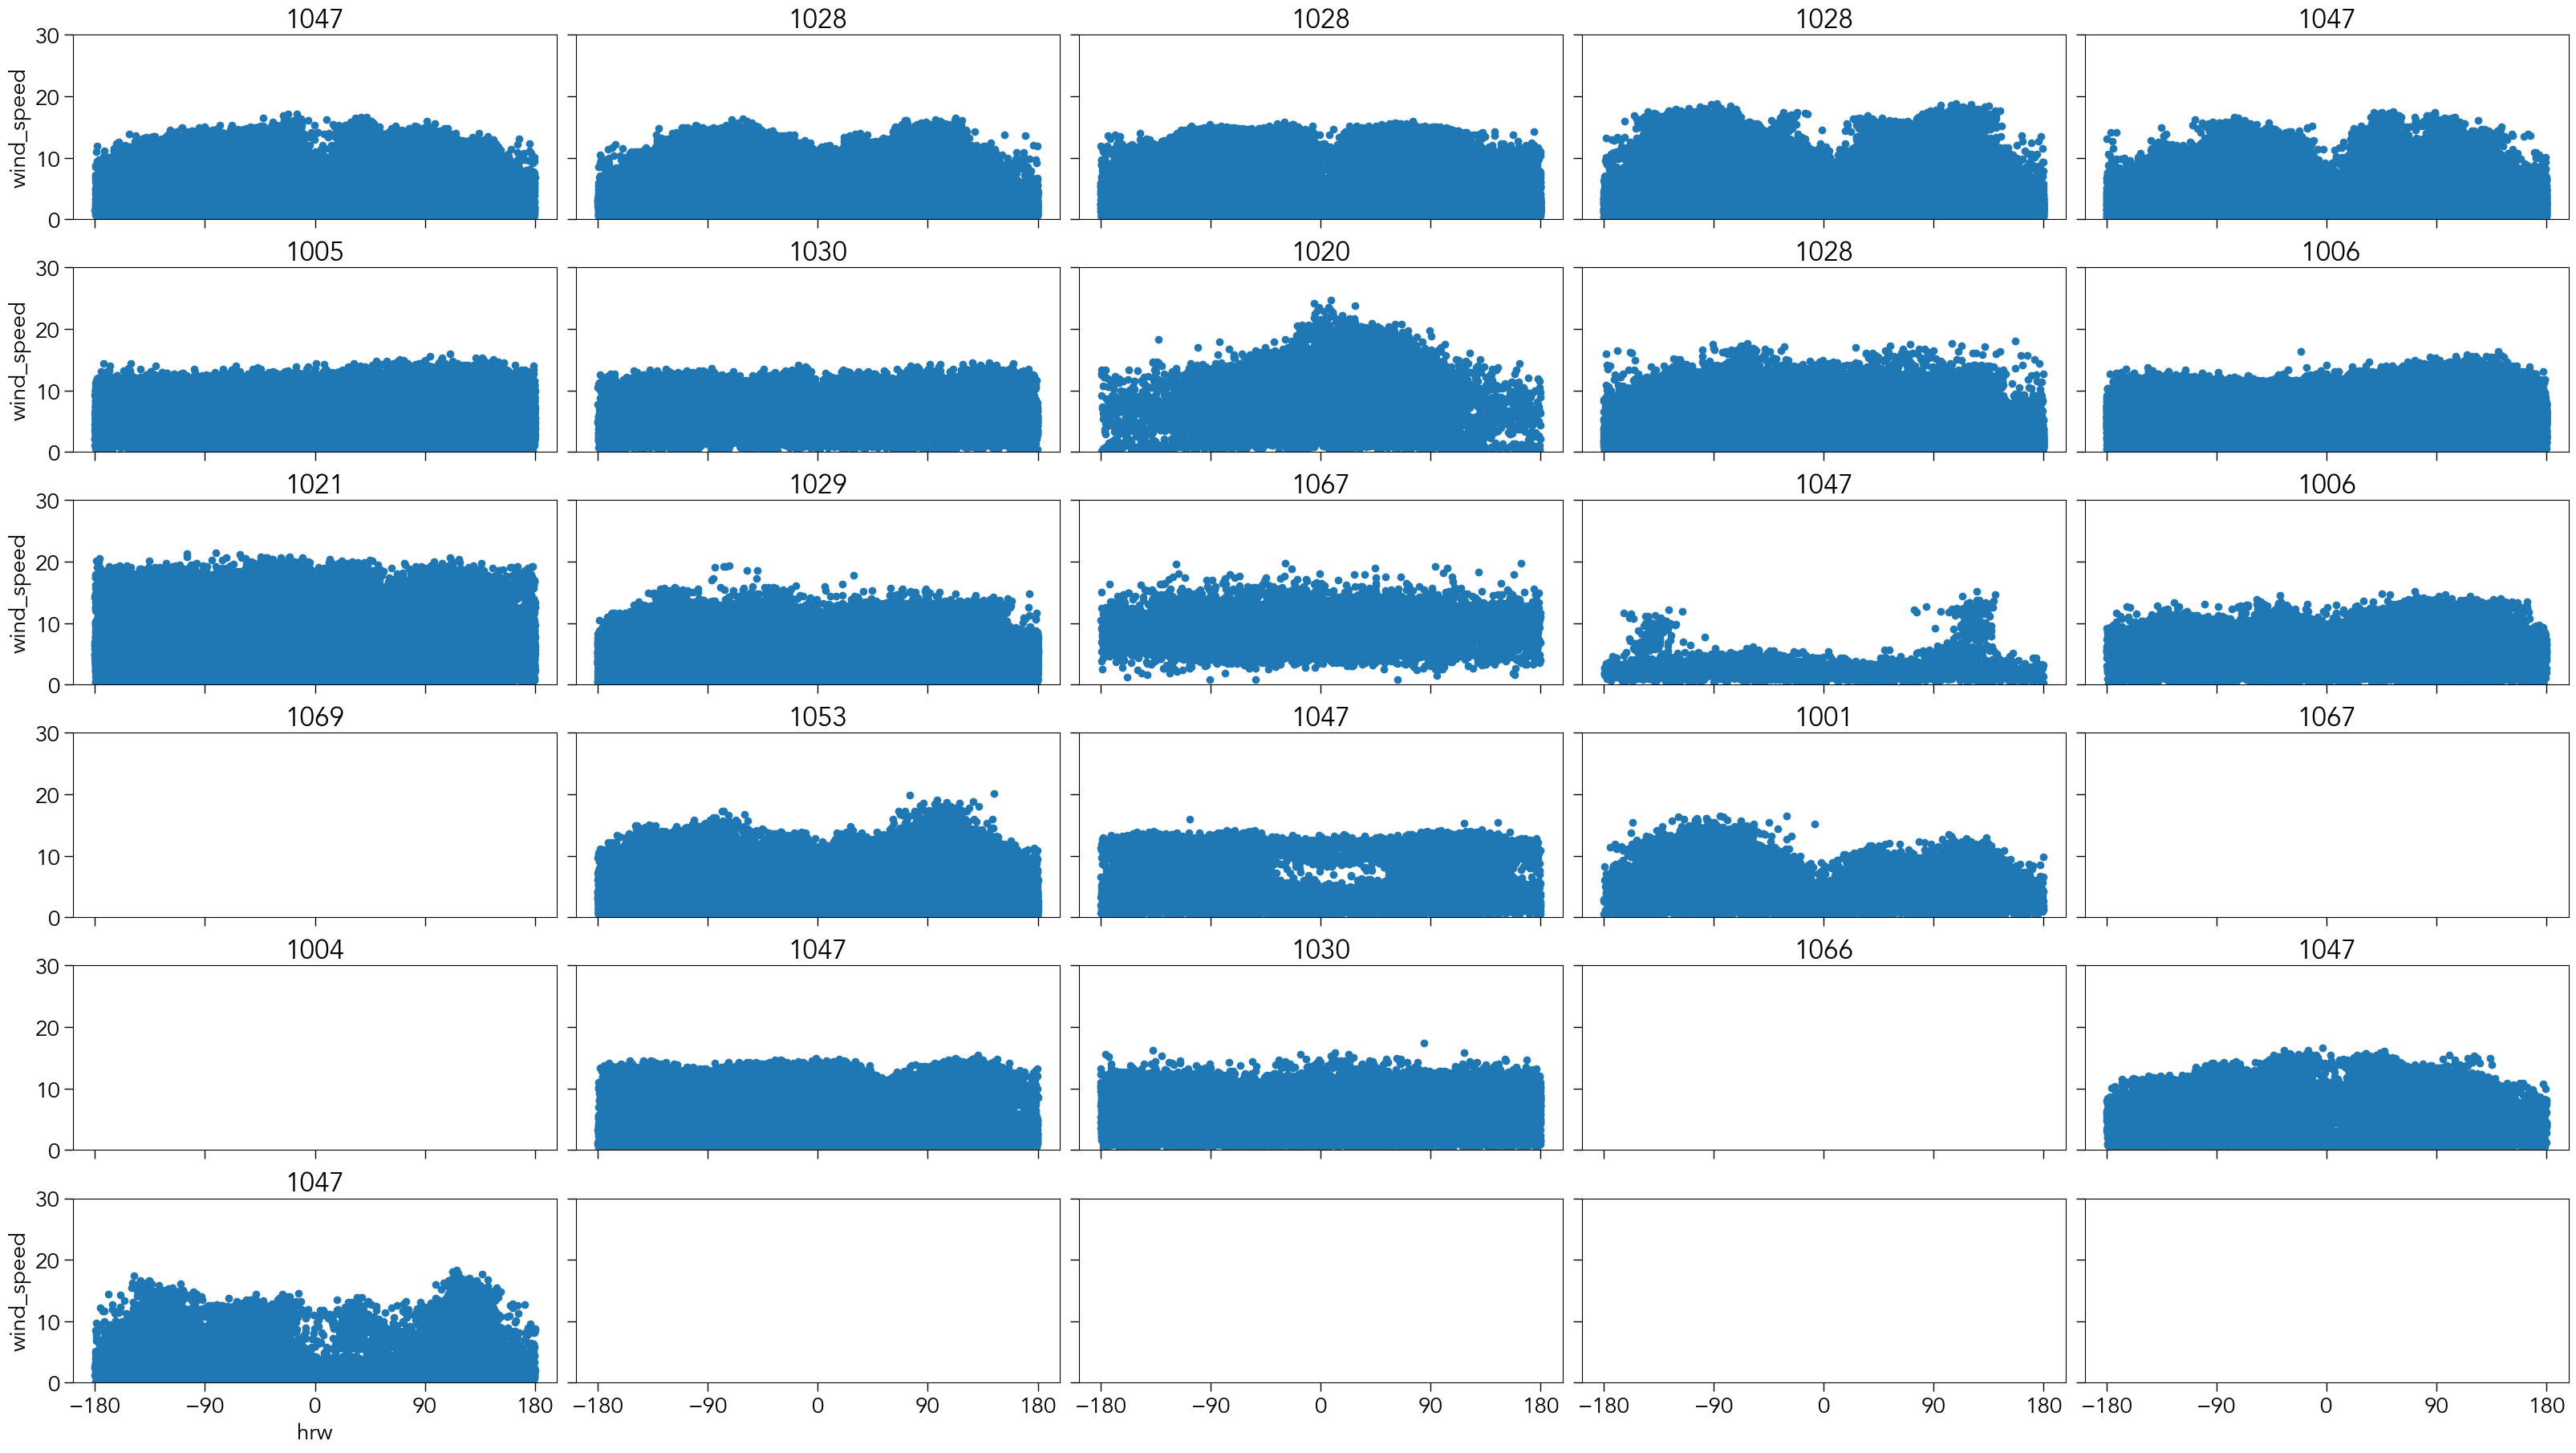

In [66]:
fig, ax= plt.subplots(6,5,figsize=(32,18),constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
for i,ds in tqdm(enumerate(DS)):
    if ('COG' not in list(ds.keys())) & ('COG' not in list(ds.keys())):
        ax[i].set(title=ds.attrs['drone_id'],ylim=(0,30))
        continue
    ds.plot.scatter(x='hrw',y='wind_speed',ax=ax[i],fc=c[i])
    ax[i].set(title=ds.attrs['drone_id'],ylim=(0,30),xticks=[-180,-90,0,90,180])
    if i < 25:
        ax[i].set_xlabel('')
    if (i)%5 != 0:
        ax[i].set_ylabel('')
        


0it [00:00, ?it/s]

IndexError: index 30 is out of bounds for axis 0 with size 30

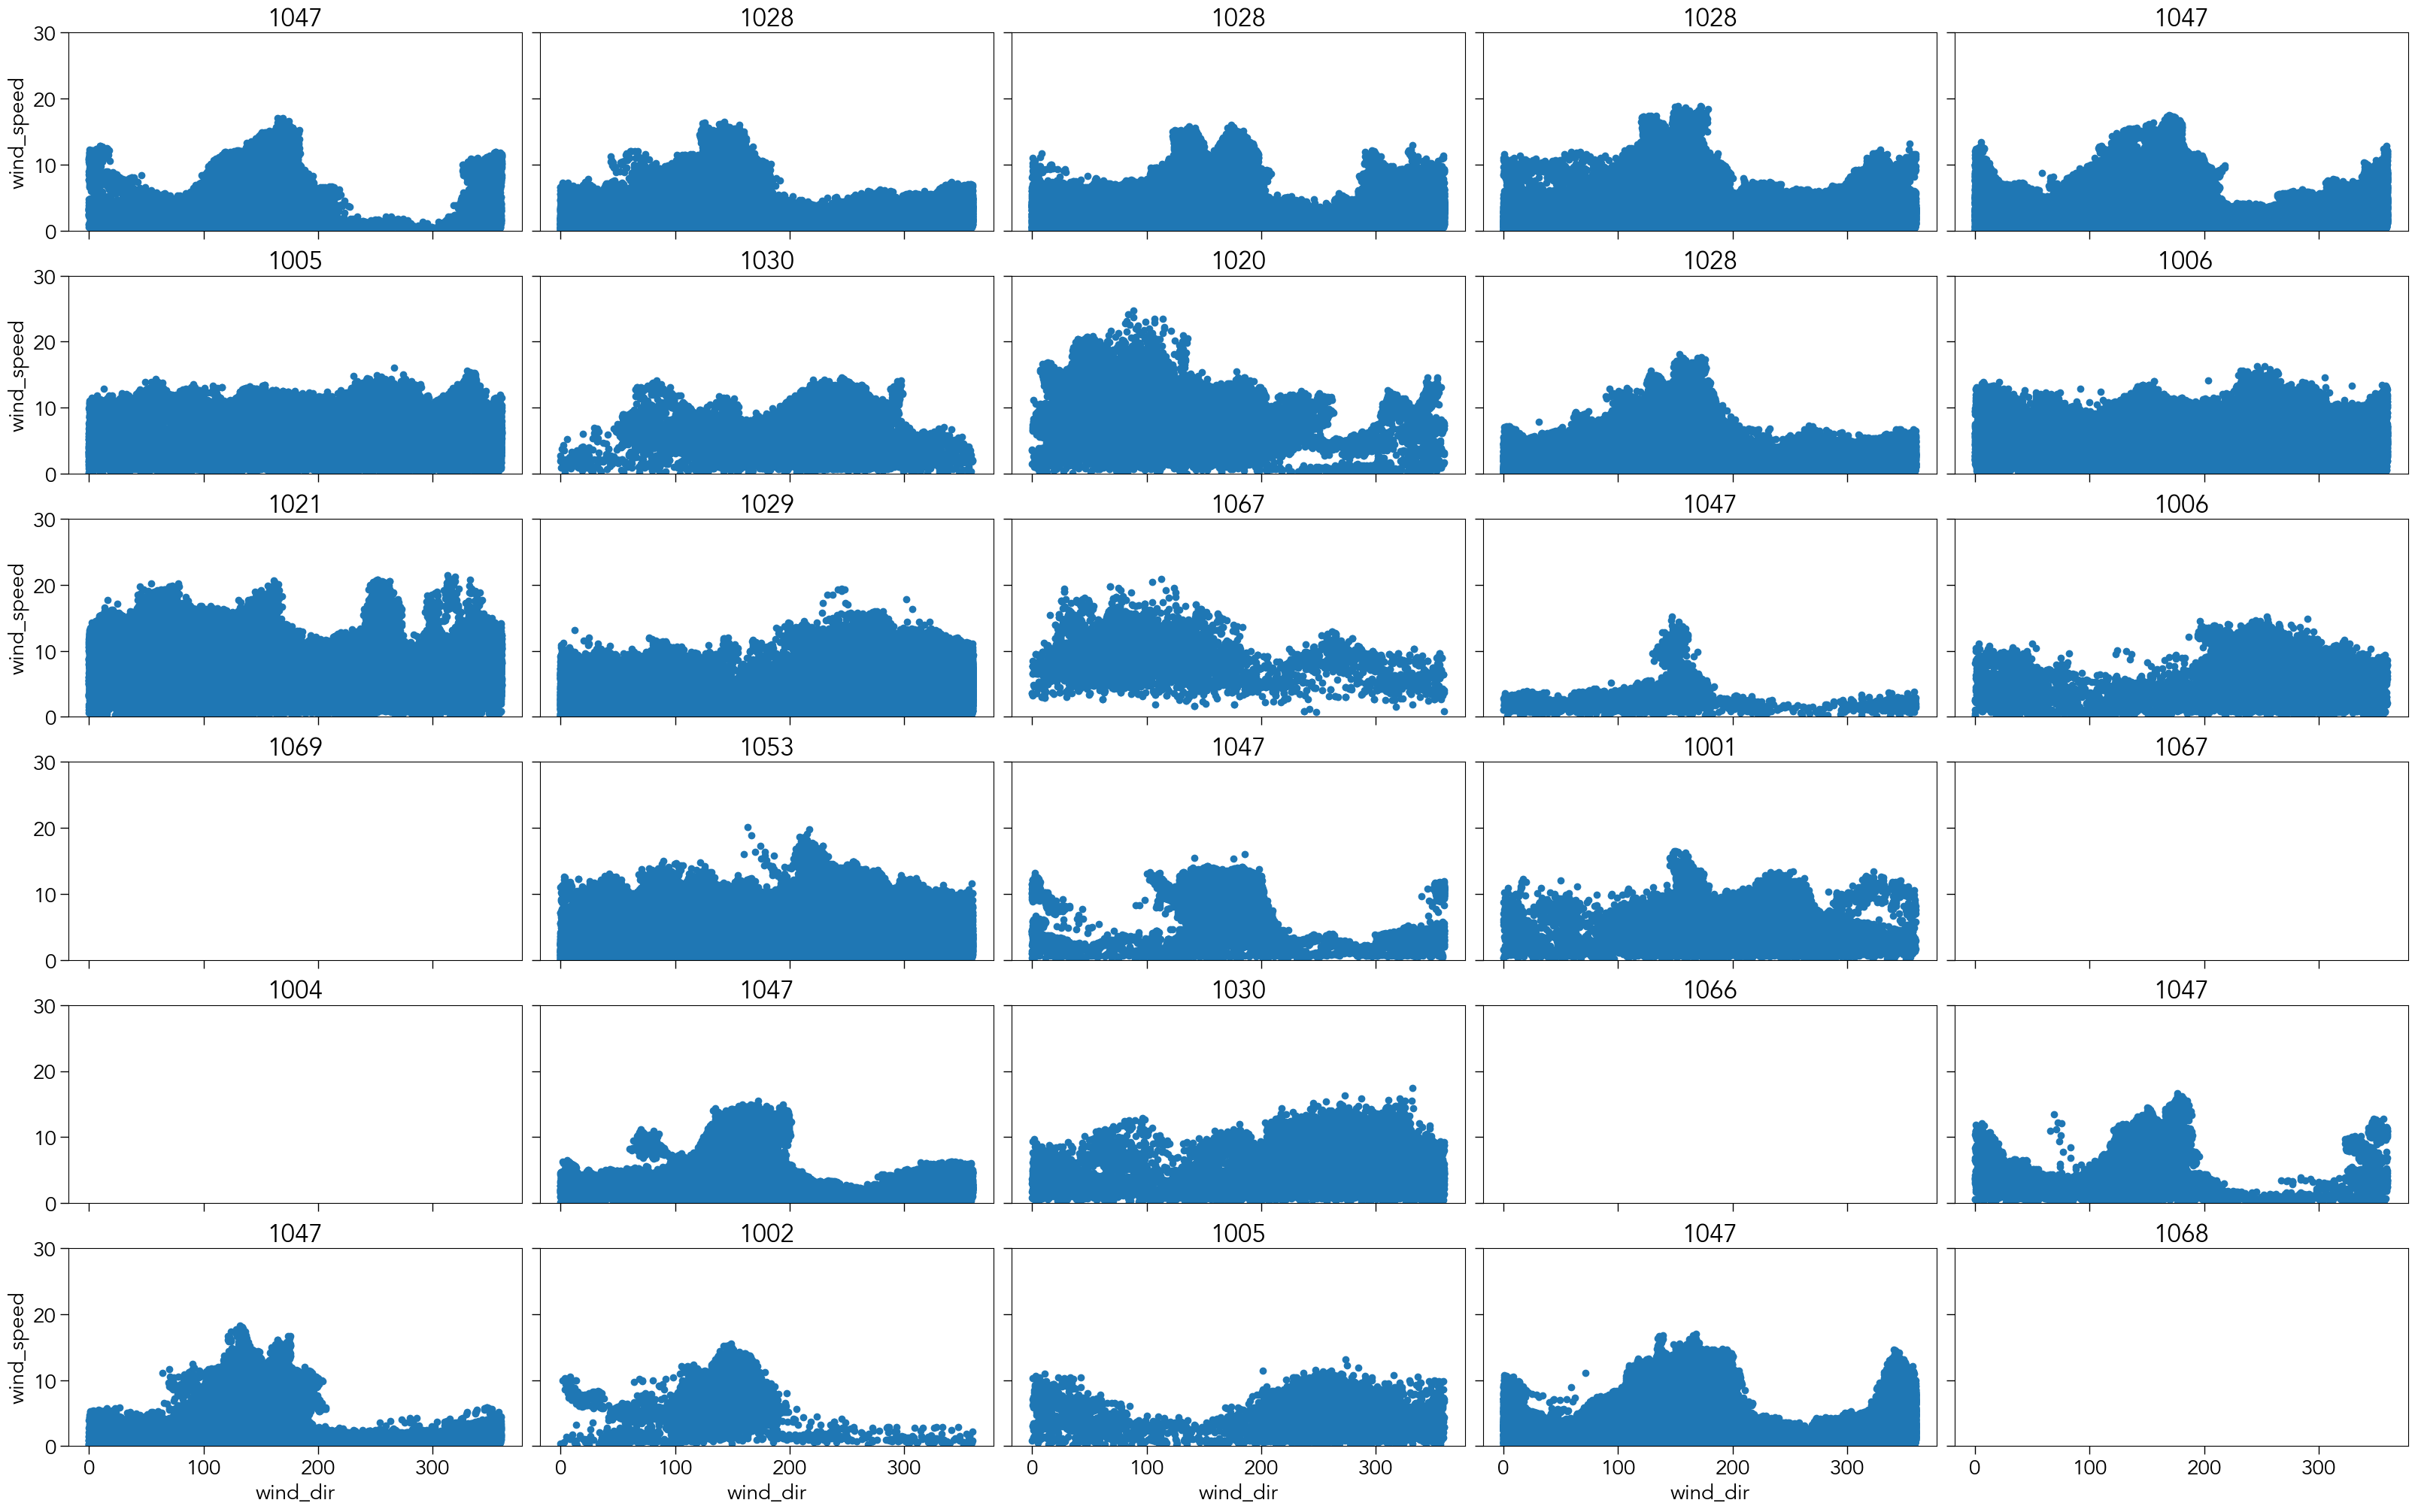

In [7]:
fig, ax= plt.subplots(6,5,figsize=(32,20),constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
for i,ds in tqdm(enumerate(DS)):
    if ('HDG' not in list(ds.keys())) & ('HDG_WING' not in list(ds.keys())):
        ax[i].set(title=ds.attrs['drone_id'],ylim=(0,30))
        continue
    ds.plot.scatter(x='wind_dir',y='wind_speed',ax=ax[i])
    ax[i].set(title=ds.attrs['drone_id'],ylim=(0,30))
    if i < 25:
        ax[i].set_xlabel('')
    if (i)%5 != 0:
        ax[i].set_ylabel('')
        


In [67]:
tmp = []
for i,ds in tqdm(enumerate(DS)):
    if 'hrw' in list(ds.keys()):
        tmp.append(ds[['hrw','wind_speed']].to_pandas().reset_index()[['hrw','wind_speed']])

0it [00:00, ?it/s]

In [68]:
tmp = pd.concat(tmp)

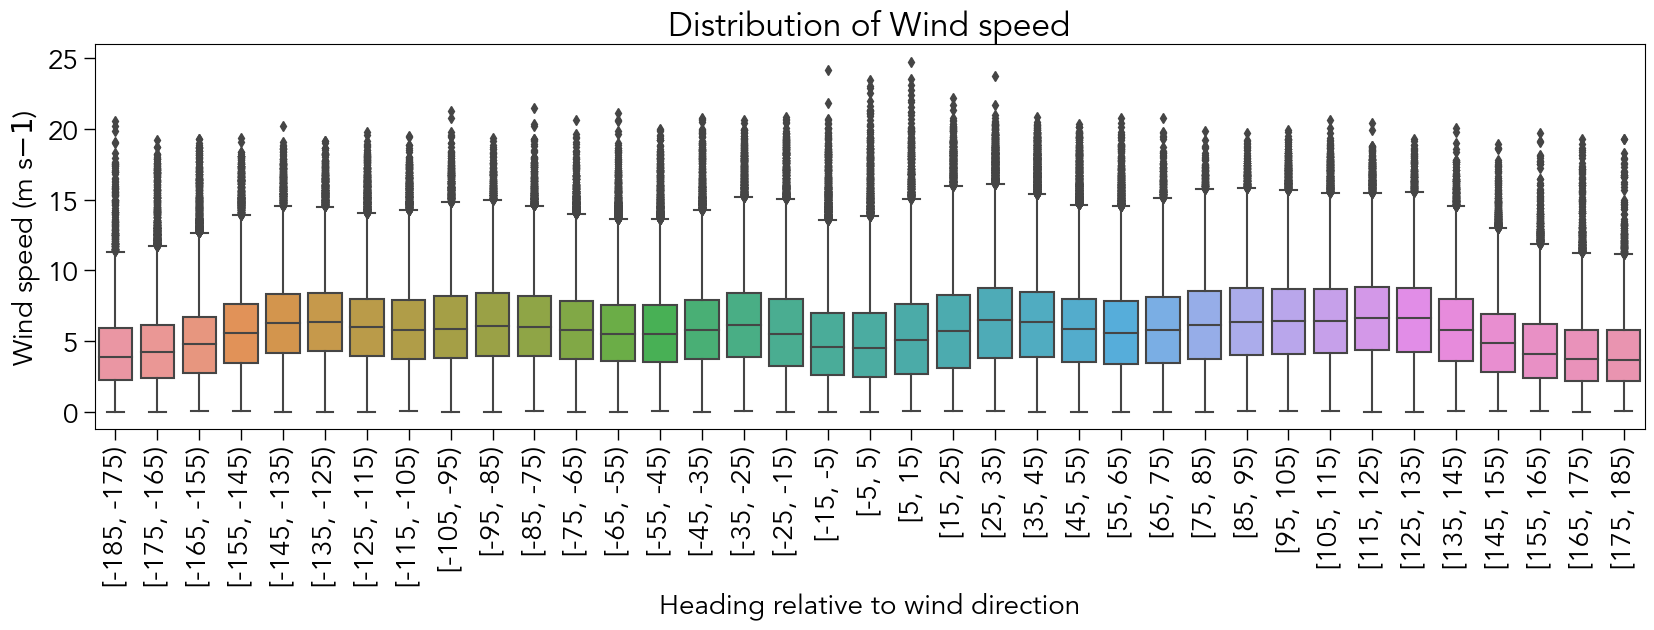

In [71]:
plt.figure(figsize=(20,5))
tmp['bins'] = pd.cut(tmp['hrw'], bins=np.arange(-185, 186, 10), right=False)
sns.boxplot(x='bins', y='wind_speed', data=tmp)
plt.xlabel('Heading relative to wind direction')
plt.ylabel('Wind speed (m s${-1}$)')
plt.title('Distribution of Wind speed')
plt.xticks(rotation=90)
plt.show()